# Content and Objective

+ Showing several aspects of diversity as, e.g., improvement of snr 

In [1]:
# importing
import numpy as np
from scipy import stats, special

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 30}
plt.rc('font', **font)
#plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(30, 12) )

# Define Function for Providing Combining Coefficients

In [3]:
########################
# combining function
########################
def my_combining( h, sigma2, method ):
    """ applies the specified combining method to a vector of realizations
    
    REMARK: perfect CSIR is assumed
    
    IN: vector h of CSIR, method to be applied as string
    
    OUT: coefficients for the combining method 
    """
    
    a = np.zeros(len(h), dtype=complex)      
    
    # switch according to requested combining scheme
    if method=='SC':
        # find index with max. channel coefficient 
        ind = np.where( np.abs(h)**2 == np.max(np.abs(h)**2) )
        a[ ind ] = 1
        
    elif method=='EGC':
        # find angles of channel coefficients and assign to a
        a = np.exp( - 1j * np.angle( h ) )
        
    elif method=='MRC':
        # find snrs and weight according to them
        a = h.conj() / sigma2
        
    else:
        raise NameError('No feasible combining method given!')
        
    # return values being normalited to norm 1
    return a / np.linalg.norm(a)


# Show Effect on SNR

### Parameters

In [4]:
# find constellation points in the IQ plane
constellation = [-1, 1]
M = 2

# EbN0 to be used for the simulation
EbN0_dB = 10

# get cariance of the noise
sigma2 = 10**(-EbN0_dB/10)

# numbers in diversity realizations 
N_diversity = np.arange(1, 31, 1)

# combining methods
comb_method = ['SC', 'EGC', 'MRC']


# initialize empty matrix for storing snrs after combining, depending on method and diversity
snr_comb = np.zeros( (len(comb_method), len(N_diversity)))


# number of realizations for every point
N_real = 1e3

### Simulation of realizations and getting snr after combining

In [5]:
# loop for combining method
for n_comb, comb_meth in enumerate( comb_method ):

    # loop for snr
    for ind_div, n_div in enumerate( N_diversity ):

        # initialize power values            
        P_x_comb = 0
        P_n_comb = 0

        # loop for realizations
        for _n in np.arange(N_real):

            # generate data symbols and build tx symbol
            d = np.random.randint(0, M)
            s = constellation[ d ]

            # generate channel and faded noisy signal
            h = 1./np.sqrt( 2 ) * ( np.random.normal( size=(n_div,) ) + 1j * np.random.normal( size=(n_div,) ) )
            noise = np.sqrt( sigma2/2 ) * ( np.random.randn( len(h) ) + 1j * np.random.randn( len(h) ) )

            # apply fading and noise
            y_fade = h * s 
            r = y_fade + noise


            # apply combining method by first getting weights, combining and measuring/updating according power values
            a_comb = my_combining(h, sigma2, comb_meth )

            r_comb = np.dot(a_comb, r)
            noise_comb = np.dot(a_comb, noise)

            P_x_comb += np.linalg.norm( r_comb - noise_comb )**2
            P_n_comb += np.linalg.norm( noise_comb )**2  

        snr_comb[ n_comb, ind_div ] = P_x_comb / P_n_comb * 10**( -EbN0_dB/10 )

### Show Results

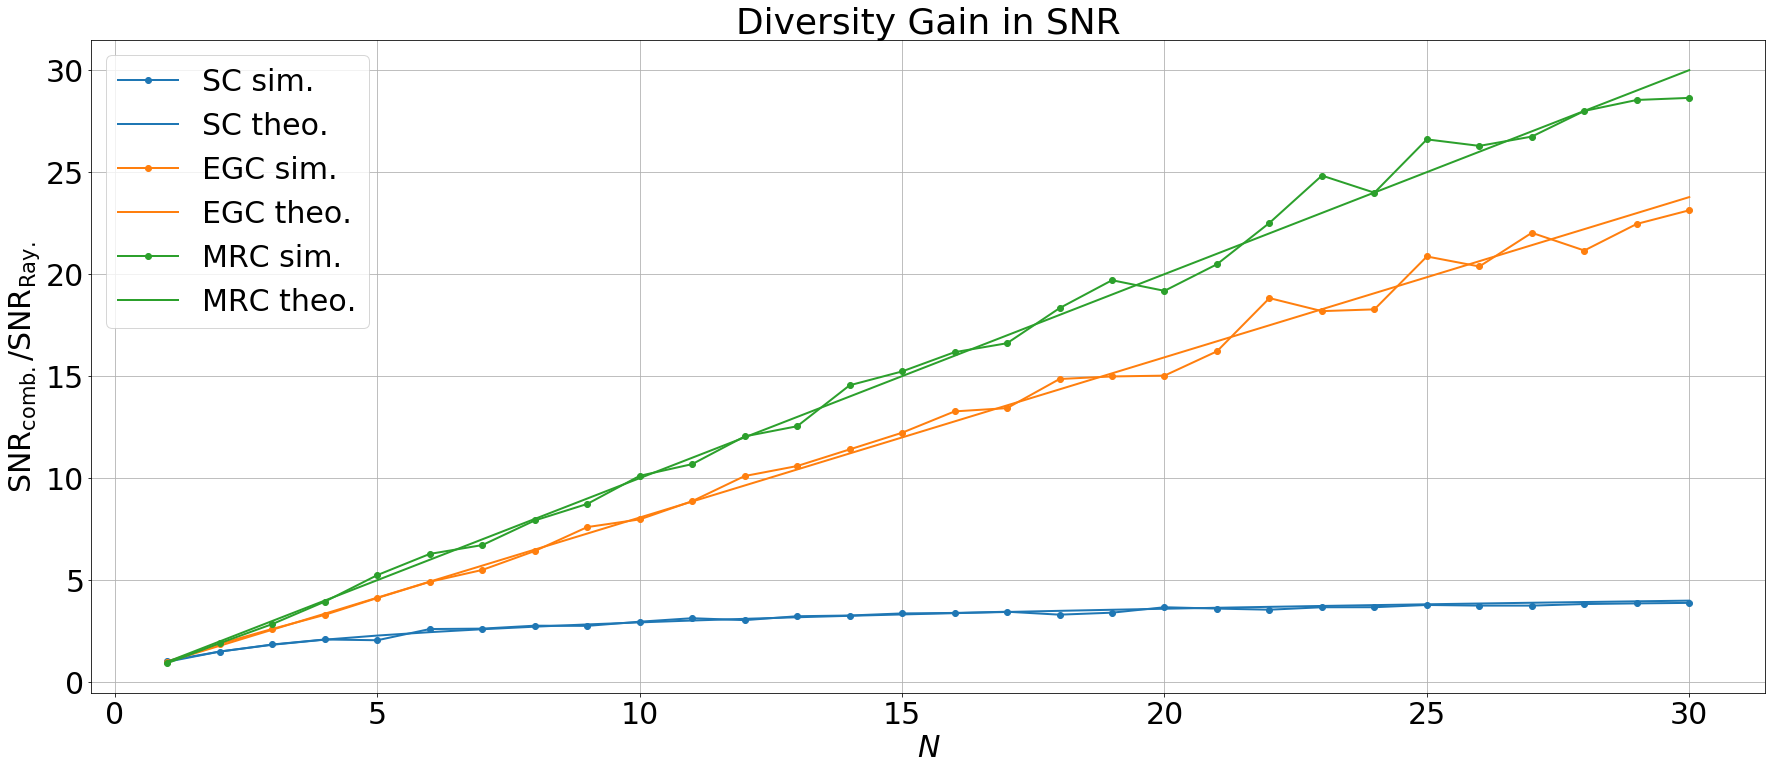

In [6]:
# theoretical values
snr_theo = np.zeros( (len(comb_method), len(N_diversity)))
snr_theo[0,:] = np.cumsum( 1.0 / N_diversity )
snr_theo[1,:] = 1 + ( N_diversity - 1 ) * np.pi/4
snr_theo[2,:] = N_diversity

# plotting
for _c, c in enumerate(comb_method):
    ax_sim = plt.plot( N_diversity, snr_comb[_c, :], '-o', label = c+' sim.', linewidth = 2.0)

    color_sim = ax_sim[0].get_color()            
    plt.plot( N_diversity, snr_theo[_c, :], color = color_sim, label = c+' theo.', linewidth = 2.0)

plt.grid(True)
plt.xlabel('$N$')
plt.ylabel('$\mathrm{SNR}_{\mathrm{comb.}}/\mathrm{SNR}_{\mathrm{Ray.}}$')
plt.title('Diversity Gain in SNR')
plt.legend(loc='upper left')